In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
import torch.autograd
import torch.nn.init
from torch.autograd import Variable
import torchvision.datasets
from sklearn import metrics
import itertools
from fs import appfs
from tqdm import tqdm
import pandas
import os
plt.style.use('fivethirtyeight')

In [3]:
use_cuda = False

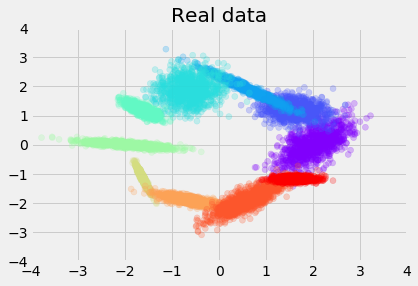

In [16]:
def gen_dataset(center, ix):
    n = 1000
    rng = np.random.RandomState(ix)
    prop_cov_mat = rng.normal(0, 0.2, size=[2, 2])
    prop_cov_mat = np.dot(prop_cov_mat.T, prop_cov_mat)
    feats = rng.multivariate_normal(center, prop_cov_mat, size=n)
    y = np.zeros([n, 10], np.float32)
    y[:, ix] = 1
    return feats[:, :2], y, np.asarray([ix]*n)

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

phis = np.linspace(0, np.pi*2, 11)[:-1]
centers = np.vstack(pol2cart(2, phis)).T

xs = []
ys = []
ixs = []
for i in range(10):
    x, y, ix = gen_dataset(centers[i], i)
    xs.append(x)
    ys.append(y)
    ixs.append(ix)
    
y = np.concatenate(ys, 0)
x = np.concatenate(xs, 0)
ixs = np.concatenate(ixs, 0)

scatter(*x.T, c=ixs, cmap='rainbow', alpha=0.25)
plt.title('Real data')
plt.ylim(-4, 4)
plt.xlim(-4, 4)
plt.savefig('plots/real.png')

In [5]:
def registering_layers(module, *layers):
    """Add a bunch of layers to a module, and return them as a list."""
    layers = list(layers)
    for ix, layer in enumerate(layers):
        if isinstance(layer, torch.nn.Linear) and hasattr(torch.nn.init, 'xavier_normal'):
            torch.nn.init.xavier_normal(layer.weight)
        module.add_module('l_{}'.format(ix), layer)
    return layers
def np_v(a, requires_grad=False):
    """
    A helper to turn numpy into torch Variables.
    """
    return Variable(np_t(a), requires_grad=requires_grad)

def np_t(a):
    """
    A helper to turn numpy into torch Variables.
    """
    return torch.from_numpy(a.astype(np.float32))

def cudify(v):
    if torch.cuda.is_available() and use_cuda:
        return v.cuda()
    else:
        return v

def uncudify(v):
    if gen.layers[0].weight.is_cuda:
        return v.cpu()
    else:
        return v
    
class Flatten(torch.nn.Module):
    def __init__(self, squeeze=False):
        super().__init__()
        self.squeeze = squeeze
        
    def forward(self, x):
        batch_size, *_ = x.size()
        if self.squeeze:
            if batch_size == 1:
                return x.squeeze().unsqueeze(0)
            else:
                return x.squeeze()
        return x.view(batch_size, -1)

class Unflatten(torch.nn.Module):
    def __init__(self, *shape):
        super().__init__()
        self.shape = shape
        
    def forward(self, x):
        batch_size, *_ = x.size()
        return x.view(-1, *self.shape)

In [6]:
class Gen(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = torch.nn.ModuleList([
            torch.nn.Linear(32, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 2),
        ])
        self.initialize()
        
    def initialize(self):
        for l in self.layers:
            if hasattr(l, 'weight'):
                torch.nn.init.xavier_normal(l.weight)
                
    def forward(self, n, y):
        x = Variable(torch.randn((n, 32-10)), requires_grad=False)
        x = torch.cat([x, y], 1)
        for layer in self.layers:
            x = layer(x)
        return x
    
    def npforward(self, n):
        return self.forward(n).data.numpy()

    
class Critic(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = torch.nn.ModuleList([
            torch.nn.Linear(10+2, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 256),
            torch.nn.ReLU(), torch.nn.Dropout(0.5),
            torch.nn.Linear(256, 256),
            torch.nn.ReLU(), torch.nn.Dropout(0.5),
            torch.nn.Linear(256, 1),
        ])
        self.initialize()
    
    def initialize(self):
        for l in self.layers:
            if hasattr(l, 'weight'):
                torch.nn.init.xavier_normal(l.weight)
            
    def forward(self, x, y):
        x = torch.cat([x, y], 1)
        for layer in self.layers:
            x = layer(x)
        return x
    
    def npforward(self, x):
        return self.forward(np_v(x)).data.numpy()

In [7]:
class ConditionalWasserstineLoss(torch.nn.Module):
    def __init__(self, generator, critic, batch_size=32, n_rounds=5):
        super().__init__()
        self.generator = generator
        self.critic = critic
        self.gen_solver = torch.optim.Adam(self.generator.parameters(), lr=5e-5)
        self.crit_solver = torch.optim.Adam(self.critic.parameters(), lr=5e-5)
        self.batch_size = batch_size
        self.n_rounds = n_rounds
        
    def forward(self, real_data, y):
        assert isinstance(real_data, Variable)
        assert isinstance(y, Variable)
        
        batch_size = real_data.size()[0]
        sampled = self.generator(batch_size, y)
        sampled_reviews = self.critic(sampled, y)
        actual_reviews = self.critic(real_data, y)
        
        interpolation_rate = torch.rand(batch_size)[:, None].expand(sampled.size())
        interpolation_rate = cudify(interpolation_rate)
        mix_samp = sampled.data
        mix_real = real_data.data
        mixture = Variable(interpolation_rate*mix_real + (1-interpolation_rate)*mix_samp, requires_grad=True)
        mixture_review = self.critic(mixture, y)
        output_loc = cudify(torch.ones(mixture_review.size()))
        
        gradients = torch.autograd.grad(
            mixture_review, 
            mixture,
            output_loc,
            create_graph=True,
            retain_graph=True,
            only_inputs=True
        )[0]
        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * 0.1
        
        critic_loss = torch.mean(sampled_reviews) - torch.mean(actual_reviews) + gradient_penalty
        generator_loss = -torch.mean(sampled_reviews)
        return critic_loss, generator_loss
    
    def sample(self, n, y):
        self.eval()
        res = self.generator(n, np_v(y))
        self.train()
        return uncudify(res).data.numpy()

    def wassertrain(self, xs, ys):
        for _ in range(self.n_rounds):
            c_loss = self.critic_step(xs, ys)
        g_loss = self.generator_step(xs, ys)
        return uncudify(c_loss).data.numpy()[0], uncudify(g_loss).data.numpy()[0]

    def draw_batch(self, xs, ys):
        batch = np.random.choice(xs.shape[0], size=self.batch_size)
        x = cudify(np_v(xs[batch]))
        y = cudify(np_v(ys[batch]))
        return x, y
    
    def critic_step(self, xs, ys):
        x, y = self.draw_batch(xs, ys)
        self.crit_solver.zero_grad()
        c_loss, _ = self.forward(x, y)
        c_loss.backward()
        self.crit_solver.step()
        return c_loss
    
    def generator_step(self,xs, ys):
        x, y = self.draw_batch(xs, ys)
        self.gen_solver.zero_grad()
        _, g_loss = self.forward(x, y)
        g_loss.backward()
        self.gen_solver.step()
        return g_loss

In [8]:
gen = Gen()
critic = Critic()
ws = ConditionalWasserstineLoss(gen, critic, batch_size=32)
g_err = []
c_err = []

try:
    del b
    bar.close()
    del bar
except NameError:
    pass
bar = tqdm(range(30000))
b = iter(bar)

  0%|          | 0/30000 [00:00<?, ?it/s]

In [9]:
os.makedirs('./plots/', exist_ok=True)
def do_plots(i):
    n = y.shape[0]
    perm = np.random.permutation(y.shape[0])
    s = ws.sample(n, y[perm])
    scatter(*s.T, c=ixs[perm], cmap='rainbow')
    plt.title('Generated points and classes')
    plt.ylim(-4, 4)
    plt.xlim(-4, 4)
    plt.savefig('./plots/points_classes_{:05d}.png'.format(i))
    plt.close()
    
    scatter(*s.T, alpha=0.5, label='Generated')
    scatter(*x[::5].T, alpha=0.5, label='Actual')
    legend()
    plt.ylim(-4, 4)
    plt.xlim(-4, 4)
    plt.title('Comparison of generated and actual points')
    plt.savefig('./plots/points_actual_{:05d}.png'.format(i))
    plt.close()
    
    scatter(*s.T, c=ws.critic(np_v(s), np_v(y[perm])).data.numpy(), cmap='inferno')
    plt.ylim(-4, 4)
    plt.xlim(-4, 4)
    plt.title('Critical review of generated points')
    plt.savefig('./plots/points_scores_{:05d}.png'.format(i))
    plt.close()
    

In [10]:
try:
    for i in b:
        if i < 25 or i % 50 == 0:
            ws.n_rounds = 100
        else:
            ws.n_rounds = 5
        cl, gl = ws.wassertrain(x, y)
        bar.set_description(str(i) + ':' + str(gl) + ":" + str(cl))
        g_err.append(gl)
        c_err.append(cl)
        if i % 1000 == 0:
            do_plots(i)
    del b
    bar.close()
    do_plots(30000)
except KeyboardInterrupt:
    pass
finally:
    pass


29999:4.70937:-0.00238922: 100%|██████████| 30000/30000 [1:04:15<00:00,  7.78it/s] 


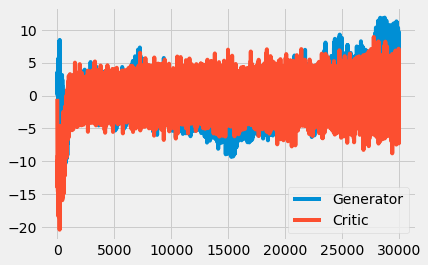

In [11]:
plot(g_err, label='Generator')
plot(c_err, label='Critic')
legend()

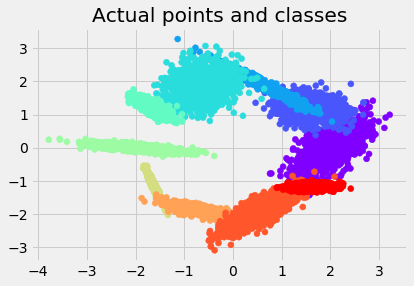

In [12]:
scatter(*x.T, c=ixs, cmap='rainbow')
plt.title('Actual points and classes')

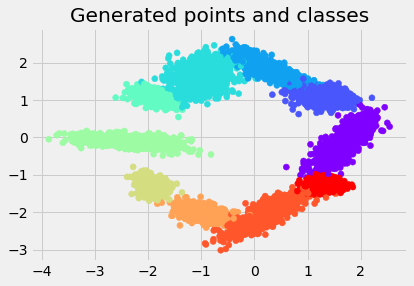

In [13]:
n = y.shape[0]
perm = np.random.permutation(y.shape[0])
s = ws.sample(n, y[perm])
scatter(*s.T, c=ixs[perm], cmap='rainbow')
plt.title('Generated points and classes')

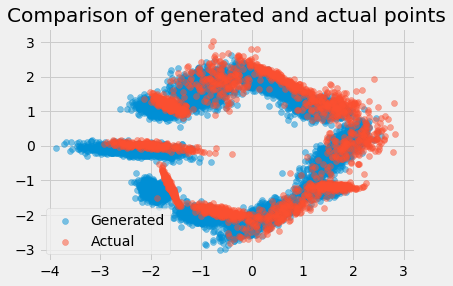

In [14]:
scatter(*s.T, alpha=0.5, label='Generated')
scatter(*x[::5].T, alpha=0.5, label='Actual')
legend()
plt.title('Comparison of generated and actual points')

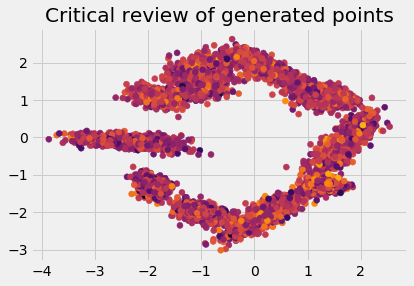

In [15]:
scatter(*s.T, c=ws.critic(np_v(s), np_v(y[perm])).data.numpy(), cmap='inferno')
plt.title('Critical review of generated points')

In [18]:
critic

Critic (
  (layers): ModuleList (
    (0): Linear (12 -> 256)
    (1): ReLU ()
    (2): Linear (256 -> 256)
    (3): ReLU ()
    (4): Dropout (p = 0.5)
    (5): Linear (256 -> 256)
    (6): ReLU ()
    (7): Dropout (p = 0.5)
    (8): Linear (256 -> 1)
  )
)